# Survey Classification Project

### Problem

We want to be able to predict how important religion is on someone's life. Specifically we want to be able to determine if if it important, not important or not at all important. We also need to consider if there is no response.

### Data

The data for this project is a set of survey answers from over 48000 participants in Europe. The questions range from things like how important are sports to you or how important is work. This is all to determine their values. Codebook.txt provides a description of each field and provides meaning to the values in the dataset.

The data has been split into 3 files: X_train, X_test and Y_train. The X files contain the covariates and the Y files contain the response variate (Importance of Religion).

### Loss Function

For this project, we will be using multi-class logarithmic loss.

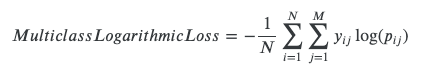

For this loss function, we want a lower score. As that means that our results are more accurate.


### Contents:
- Data Cleaning/Preprocessing
- Dealing with Missing Values
- Multicollinearity/Covariance Matrix
- Tree-Related Variable Selection
- Fitting a Logistic Regression Model
- Fitting a Random Forests Model
- Fitting a Gradient Boosted Model

Here, I have added all my packages, data and coded up the loss function.

In [1]:
# Package Loading
import numpy as np
import pandas as pd
import matplotlib as plt

In [128]:
import math
def loss(pred, label):
  sum = 0
  length = len(label)
  for i in range(length):
    l = label[i]
    if l == -1:
      l = 0

    sum += math.log(pred[i][l])

  return (- (1/length) * sum)

In [253]:
# Data Loading
data = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv").iloc[:, 1:]

print(data.shape)
print(y.shape)

(48000, 438)
(48000, 1)


### Data Preprocessing/Cleaning

Here, I remove variables that are either unneeded, or ones that did not provide useful information (mostly blank or don't provide any insight) Specific reasoning in the comments.

In [254]:
# Removing Columns that only have one unique value (Unique Values: 1)
no_same_vals = data.drop(columns=["v72_DE", "v73_DE", "v74_DE", "v75_DE", "v76_DE", "v77_DE", "v78_DE", "v79_DE"])

# Removing Time variables that are unneeded/super specific
no_times = no_same_vals.drop(columns=["v278a", "v278b", "v278c_r", "v279a", "v279b", "v279c_r", "v282", "fw_start", "fw_end"])

# Removing the String Vars that have been numerized
no_string_converts = no_times.drop(columns=["c_abrv", "v228b", "v231b", "v233b", "v251b", "v281a", "v275b_N2", "v275b_N1", "v275c_N1", "v275c_N2"])

# Removing Country-specific Vars
no_cs = no_string_converts.drop(columns=["v52_cs", "v174_cs", "v175_cs", "v243_cs", "v243_cs_DE1", "v243_cs_DE2", "v243_cs_DE3", "v243_cs_GB1",
                                         "v243_cs_GB2", "v252_cs", "v252_cs_DE1", "v252_cs_DE2", "v252_cs_DE3", "v252_cs_GB1", "v252_cs_GB2",
                                         "v262_cs", "v262_cs_DE1", "v262_cs_DE2", "v262_cs_DE3", "v262_cs_GB1", "v262_cs_GB2", "v263_cs",
                                         "v263_cs_DE1", "v263_cs_DE2", "v263_cs_DE3", "v263_cs_GB1", "v263_cs_GB2"])

# Removing Any Variables that are inconsistency flags
new_df = no_cs.drop(columns=["f20", "f30a", "f45a", "f85", "f96", "f110", "id"])

print(new_df.shape)

(48000, 377)


### Missing Values

Just made them all -3. This is the default value for the columns with missing values.

In [255]:
filled_in = new_df.fillna(value=-3)

### Multicollinearity/Covariance Matrix

Removed any highly correlated covariates. (So that the data could be used to logisitic regression and also as a means of variable selection)

In [256]:
# Correlation
correl = filled_in.corr().abs()

# upper triangle
upper = correl.where(np.triu(np.ones(correl.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

filled_in.drop(to_drop, axis=1, inplace=True)
filled_in.shape

(48000, 290)

### Variable Selection Using LASSO

Here we attempt to do variable selection using LASSO.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(filled_in, y, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)

s = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
s.fit(scaler.transform(X_train), y_train)

X_train_selected = s.transform(scaler.transform(X_train))

X_train_selected.shape

Unfortunately, it looks like LASSO didn't help us out too much. Let's try a different method for Variable Selection.

## Tree Libraries for Variable Selection

Used to select variables with respect to gain/deviance. Specifically, let's use the Random Forest Classifer.

In [257]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # To standardize variables

X_train, X_test, y_train, y_test = train_test_split(filled_in, y, random_state=0)
pipe = make_pipeline(StandardScaler(), SelectFromModel(RandomForestClassifier()))
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier()))])

In [258]:
selected_feat = X_train.columns[pipe.steps[1][1].get_support()]
len(selected_feat)

74

In [259]:
print(selected_feat)

Index(['country', 'v5', 'v38', 'v39', 'v51', 'v52', 'v54', 'v55', 'v56', 'v57',
       'v58', 'v59', 'v62', 'v63', 'v64', 'v81', 'v82', 'v83', 'v84', 'v93',
       'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v115', 'v133', 'v134',
       'v136', 'v137', 'v138', 'v139', 'v140', 'v143', 'v144', 'v151', 'v153',
       'v154', 'v155', 'v156', 'v157', 'v158', 'v159', 'v160', 'v161', 'v163',
       'v174_LR', 'v175_LR', 'v185', 'v186', 'v187', 'v188', 'v196', 'v198',
       'v218', 'v226', 'age', 'v241', 'v242', 'v243_edulvlb', 'v246_ISCO_2',
       'v246_SIOPS', 'v252_edulvlb', 'v252_ISCED_2', 'v255_ISCO_2',
       'v255_SIOPS', 'v261', 'v262_edulvlb', 'v263_edulvlb', 'v266', 'v276_r',
       'v279d_r', 'v281a_r'],
      dtype='object')


Yay! We have 74 variables that we've narrowed it down to!!! Let's look at the most important of them.

In [260]:
feature_scores = pd.Series(pipe[1].estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores[0:20]

v63        0.046514
v64        0.028760
v56        0.022290
v54        0.019548
v115       0.017700
v57        0.015136
v62        0.013708
v52        0.012537
v5         0.012061
v51        0.011665
v93        0.011492
v154       0.010435
v59        0.007770
age        0.007513
v279d_r    0.007426
v226       0.007199
country    0.007068
v156       0.006969
v55        0.006914
v155       0.006723
dtype: float64

The highest being 0.04. We can see that v63 indicates the question "How important is god in your life". Which is clearly related to how important religion is. v64, v54, v56, v57, v115, v62, v52, v93, v51,  are all actually church/relgion related which is extremely interesting given that we're trying to pick out how important religion is to one's life.

The other more important ones are v5 (importance of politics), v154 (justify abortion), age. These are all variates that are closely tied to religion, which is extremely interesting.

Let's try to fit a logistic regression model using these data

### Fitting a Logistic Regression Model

Next, let's look at logisitic regression.

In [261]:
# Fitting a Log Regression Model using the first 20 variables
from sklearn.linear_model import LogisticRegression

variates = ["v64", "v54", "v115", "v56", "v52", "v57", "v62", "v93", "v5", "v63"]

l_data = filled_in[variates]

X_tr1, X_te1, y_tr1, y_te1 = train_test_split(l_data, y, random_state=0)

pipe_log1 = make_pipeline(StandardScaler(), LogisticRegression())

pipe_log1.fit(X_tr1, y_tr1.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [262]:
pred = pipe_log1.predict_proba(X_te1)
print(loss(pred, y_te1.values.ravel()))

1.0173444960848146


So we have that the loss is 1.017 from the logistic regression model.

### Fitting a Random Forests Model on Reduced Dataset

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(l_data, y, random_state=0, test_size=0.35)
pipe_tree = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=11, max_leaf_nodes=150))
pipe_tree.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=11, max_leaf_nodes=150))])

In [264]:
pred_tree = pipe_tree.predict_proba(X_test)
loss(pred_tree, y_test.values.ravel())

0.9487014439892211

The loss here is 0.949. This is better than the logistic regression model!

Let's try to make a tree with the full model (basically filled_in)

### Random Forests with Full Dataset (not the reduced one)

Spoiler: Doesn't do much either

In [265]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(filled_in, y, random_state=0, test_size=0.35)
pipe_tree1 = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=15, max_leaf_nodes=60))
pipe_tree1.fit(X_train_f, y_train_f.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, max_leaf_nodes=60))])

In [266]:
pred_tree1 = pipe_tree1.predict_proba(X_test_f)
loss(pred_tree1, y_test_f.values.ravel())

1.0301783929596862

Here the loss is 1.026. This is worse than the reduced model. But that is kinda expected.

Let's try Boosting!

### Fitting a Gradient Boosted Model

In [270]:
from sklearn.ensemble import GradientBoostingClassifier

X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(l_data, y, random_state=0, test_size=0.2)
pipe_xg = make_pipeline(StandardScaler(), GradientBoostingClassifier())
pipe_xg.fit(X_train_xg, y_train_xg.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [271]:
pred_xg = pipe_xg.predict_proba(X_test_xg)
print(pred_xg)
print(y_test_xg.values.ravel())
print(loss(pred_xg, y_test_xg.values.ravel()))

[[0.01048148 0.16513164 0.47923231 0.27180478 0.07334979]
 [0.01446918 0.03112697 0.1282472  0.61574113 0.21041553]
 [0.00177848 0.81021602 0.11713724 0.03970787 0.03116039]
 ...
 [0.00626209 0.01569877 0.03797914 0.1735022  0.7665578 ]
 [0.00512032 0.00982002 0.06402401 0.71896465 0.202071  ]
 [0.00238689 0.0039272  0.01349926 0.06445231 0.91573433]]
[2 4 1 ... 4 4 4]
0.929318549099382


XGBoost seemed to work very well.. Here we have that the loss value is 0.929.

Now let's make a function that'll convert the probabilities to a format that is easy to check for our loss function:


id, no_answer, very important, quite important, not important, not at all important

In [252]:
def convert_to_final_format(probs):
  length = len(probs)
  id = list(range(length))
  df = pd.DataFrame(probs)
  df = df.rename(columns={0: "no answer", 1: "very important", 2: "quite important", 3: "not important", 4: "not at all important"})
  df.insert(0, "id", id, True)
  df.to_csv("predictions.csv", index=False)

#convert_to_final_format(pred_xg)

In [273]:
# We need to transform the X_train for submission
# Load Xtest
Xtest = pd.read_csv("X_test.csv")

,id,year,fw_start,fw_end,country,c_abrv,v1,v2,v3,v4,...,v278b,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a,v281a_r,v282
0,0,2019,201907,201912,499,ME,1,1,1,1,...,13,15.13,16,42,16.42,89,2,cnr,186,1
1,1,2019,201907,201912,499,ME,2,1,2,2,...,33,12.33,13,58,13.58,85,2,cnr,186,1
2,2,2019,201907,201912,499,ME,1,1,2,2,...,9,11.09,12,3,12.03,54,2,cnr,186,1
3,3,2019,201907,201912,499,ME,1,1,2,1,...,15,10.15,11,18,11.18,63,2,cnr,186,1
4,4,2019,201907,201912,499,ME,1,1,1,1,...,10,13.10,14,55,14.55,105,1,cnr,186,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11433,11433,2018,201802,201807,826,GB,2,1,2,2,...,3,16.03,16,39,16.39,36,1,en,128,4365
11434,11434,2018,201802,201807,8,AL,1,1,2,3,...,0,17.00,17,35,17.35,35,1,sq,13,3
11435,11435,2018,201802,201808,348,HU,1,1,2,1,...,18,11.18,12,3,12.03,45,1,hu,184,104
11436,11436,2018,201801,201805,40,AT,2,1,2,1,...,24,12.24,13,25,13.25,61,1,de,158,44


In [274]:
# Transforming Xtest
transformed = Xtest[variates]

,v64,v54,v115,v56,v52,v57,v62,v93,v5,v63
0,3,6,3,1,-3,1,1,1,1,5
1,4,3,2,1,8,1,1,2,2,6
2,4,3,1,1,8,1,4,1,3,4
3,6,6,-1,1,-3,1,1,2,2,9
4,4,5,1,-1,8,1,4,2,2,8
...,...,...,...,...,...,...,...,...,...,...
11433,7,7,3,2,-3,2,4,2,2,1
11434,1,3,3,1,5,1,1,1,4,10
11435,2,4,3,1,1,1,1,2,2,5
11436,6,4,3,-1,1,1,2,2,3,6


In [276]:
test_pred = pipe_xg.predict_proba(transformed)

array([[0.00911153, 0.43177542, 0.37324148, 0.14637525, 0.03949632],
       [0.00590764, 0.16606663, 0.70497852, 0.10985917, 0.01318804],
       [0.00473683, 0.40926325, 0.39216542, 0.17166309, 0.02217141],
       ...,
       [0.00643974, 0.04938779, 0.57777427, 0.3398263 , 0.0265719 ],
       [0.01596347, 0.01822293, 0.2498815 , 0.68281214, 0.03311996],
       [0.00167375, 0.72759554, 0.24625129, 0.02028063, 0.0041988 ]])

In [277]:
convert_to_final_format(test_pred)